# 0. Import libraries and dataset

In [21]:
import pandas as pd

Welcome in our notebook!

Through various stages we will : 

- create databases listing the history of financial crises over the last two centuries for groups of up to 70 countries.

- show the differences in the reaction of the inflation rate and output as a function of the duration of these financial crises.

- show that the period until economic recovery decreases with the duration of the crisis. 

- show that the length period without crises can have an importance on the severity of the next financial crisis.

The first step is to import the `Global Crises Data by Country` dataset and the `Maddison Project Database 2020` and to preprocess the two dataset with the functions from the `preprocess_dataset` module. The functions are renaming, dropping and changing the data type of certain columns or rows for clarity purpose.


In [22]:
from preprocess import preprocess_global_crises_data
from preprocess import preprocess_mdp_data

# Change the paths of the dataset according to their location
global_crises_dataset_path = '../raw_data/global_crisis_data_country.csv'
maddison_databse_path = '../raw_data/gdp-per-capita-maddison.csv'

# Read the Global Crises Dataset with the 'unicode_escape' encoding to handle special characters
main_data = pd.read_csv(global_crises_dataset_path, encoding='unicode_escape')
GDP_pc = pd.read_csv(maddison_databse_path)

# Preprocess the dataset (explanations in the preprocess.py file)
preprocess_global_crises_data(main_data)
preprocess_mdp_data(GDP_pc)

# 1. Countries selection and dataset analysis

## Country Lists

The following lists contain country codes representing different groups of countries 🌍.  

The last list `ALL` is created by taking the intersection of unique country codes present in two datasets (`data` and `GDP_pc`). It contains the list of all unique country codes present in both datasets.

In [23]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
EU = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#List for all countries
unique_countries_df1 = set(main_data['CC3'].unique())
unique_countries_df2 = set(GDP_pc['Code'].unique())
ALL = list(unique_countries_df1.intersection(unique_countries_df2))

In [24]:
#Select a list among those listed above. Change to any desired list defined above.
countries_selected = G20

## Dataset selection and creation

This cell creates a dataset containing the data for the countries selected.

- The `concat_dataset` function is called to create a dataset (`global_data_left`) by concatenating the data from two datasets (`data` and `GDP_pc`) for the selected countries with a type of jointure `Left`.

- The `dummy_variable` function is applied to the `global_data` dataset to create some necessary variable to the following analysis.

The resulting `global_data` dataset contains the merged data for the selected countries, along with any additional preprocessing applied by the `dummy_variable` function.


In [25]:
from dataset import concat_dataset
from dataset import dummy_variable

#Create a dataset with the data of the countries of the list
global_data_left = concat_dataset(main_data, GDP_pc, countries_selected, 'left')

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_left)

# Display the resulting dataset (here the first 5 rows)
global_data_left.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,23.0,DEU,Germany,1800,0.0,NaN,0.0,0,3.1746,NaN,...,NaN,-12.3,1,0,0.0,-7.3,0,0,0,1
1,23.0,DEU,Germany,1801,0.0,NaN,0.0,0,2.7397,NaN,...,NaN,-7.1,1,0,0.0,NaN,0,0,0,1
2,23.0,DEU,Germany,1802,0.0,NaN,0.0,0,2.7397,NaN,...,NaN,46.5,1,0,1.0,NaN,0,1,0,0
3,23.0,DEU,Germany,1803,0.0,NaN,0.0,0,2.8571,NaN,...,NaN,3.7,1,0,0.0,NaN,0,0,0,1
4,23.0,DEU,Germany,1804,0.0,NaN,0.0,0,2.8169,NaN,...,NaN,-9.9,1,0,0.0,NaN,0,0,0,1


## Analysis of the banking crises and their duration in the dataset

Compute the duration of each banking crisis of the dataset and provide a distribution of crisis durations in the dataset.

- The `compute_crisis_duration` calculates a list of duration of crisis events in years in the `global_data_left` dataset.
The result is assigned to the `crisis_duration_left` variable.

- The `length_frequency` function creates a table showing the number of crisis occurences of each duration in years.
The results is a dataframe which is assigned to the variable `frequency_table_left`.

In [26]:
from extraction_method_2 import compute_crisis_duration
from extraction_method_2 import length_frequency

# Calculate the duration of crisis events
crisis_duration_left = compute_crisis_duration(global_data_left)

# Compute the frequency of different crisis durations
frequency_table_left = length_frequency(crisis_duration_left)
frequency_table_left

,Length in years,Count
0,1,27
1,2,14
2,3,7
3,4,5
4,7,2
5,8,1
6,10,1


# 2. Annual inflation rate analysis

## Extraction of the inflation rate series
In this cell we : 
- extract the inflation series from the `global_data_left` dataset using the `extract_inflation_series` function from the `extraction_method_1` module.

- normalize the extracted inflation series to the first element of each serie (ts-1) data using the `normalize_crisis_data` function.

- store the result in the list `norm_inflation_series`.

In [27]:
from extraction_method_2 import extract_inflation_series
from extraction_method_2 import normalize_serie

inflation_series = extract_inflation_series(global_data_left)
norm_inflation_series = normalize_serie(inflation_series)

## Visualization of Inflation Rate reaction by Crisis Length

This cell visualizes average reaction of the inflation rate to a banking crisis depending on the crisis length using functions from the `visualisation` module.

The `plot_by_crisis_length` function can be called with the following 5 arguments:
  - `norm_inflation_series`: The normalized inflation series data.
  - `crisis_duration_left`: The list containing the duration of each crisis event.
  - `frequency_table_left`: The DataFrame containing the frequency of each crisis duration.
  - `'Inflation rate'`: The label for the y-axis of the plot.
  - `desired_length`: The duration of the banking crisis to which the inflation rate reacts.

The `plot_all_crisis_length` function can be called with the first 4 arguments listed above and can plot the average reaction of the inflation rate to to all the different durations of banking crises.

The resulting plots visualizes the difference of reaction of the inflation rate to banking crisis of different length. The plots are also displaying the number of data points from which the average has been computed.

In [28]:
from visualisation import plot_by_crisis_length
from visualisation import plot_all_crisis_length

Uncomment the following cell to plot the reaction for a specific length of banking crisis 📈📉.

In [29]:
# # Change to the desired duration of crisis
# desired_length = 1 #year(s)

# # Plot the average reaction of the inflation rate to a banking crisis of a particular length specified in the last argument of the following function
# plot_by_crisis_length(norm_inflation_series, crisis_duration_left, frequency_table_left, 'Inflation rate', desired_length)

Uncomment the following cell to plot the reaction for every length of banking crisis 📈📉.

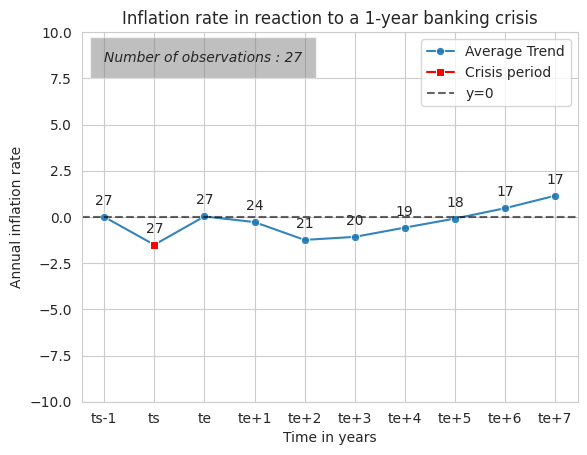

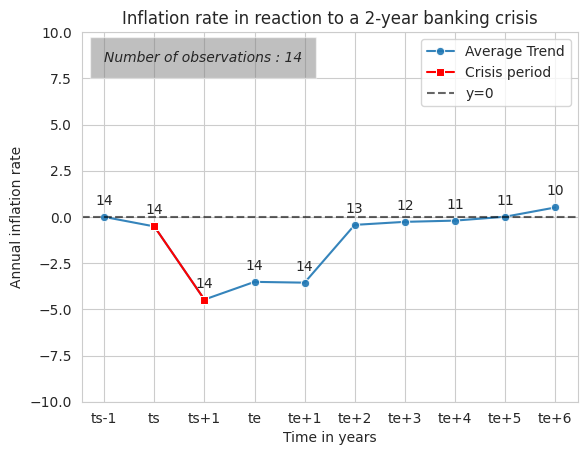

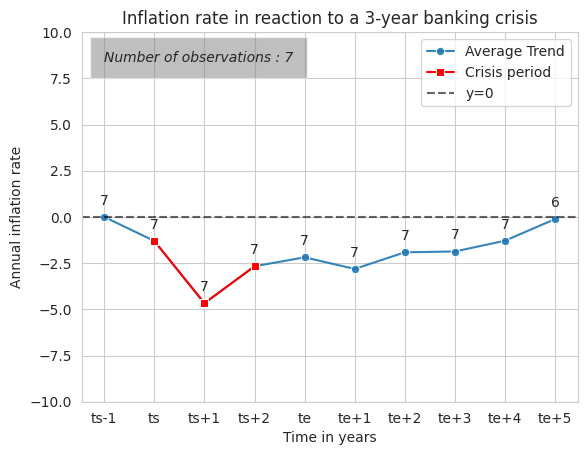

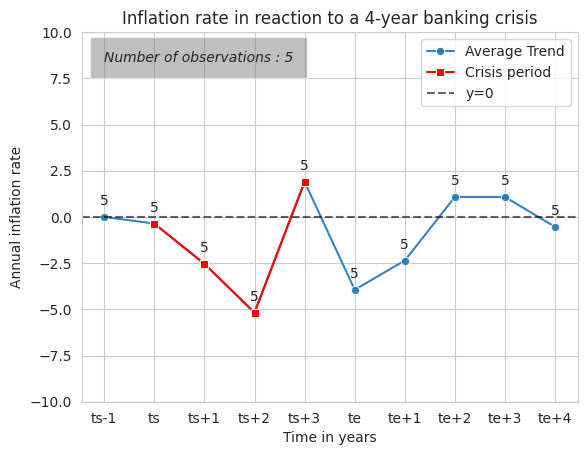

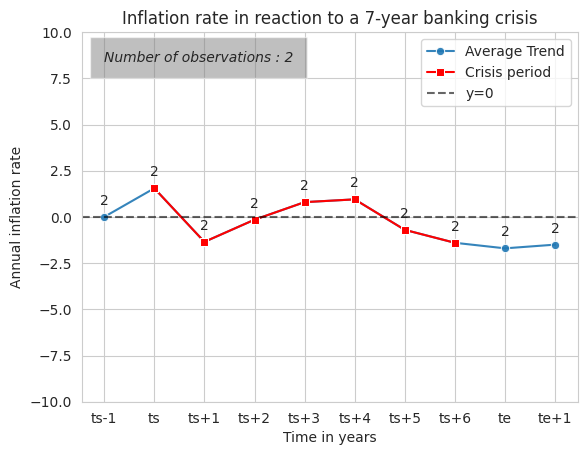

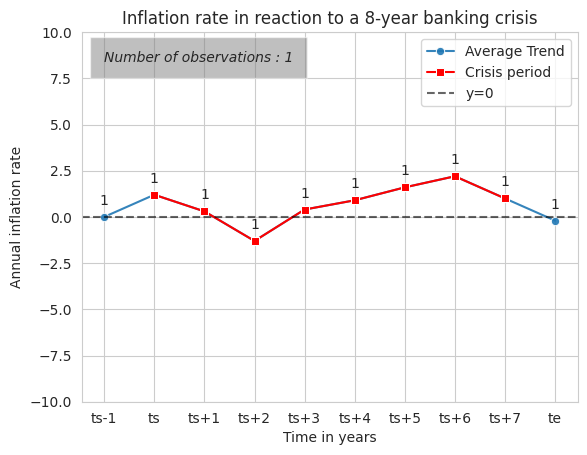

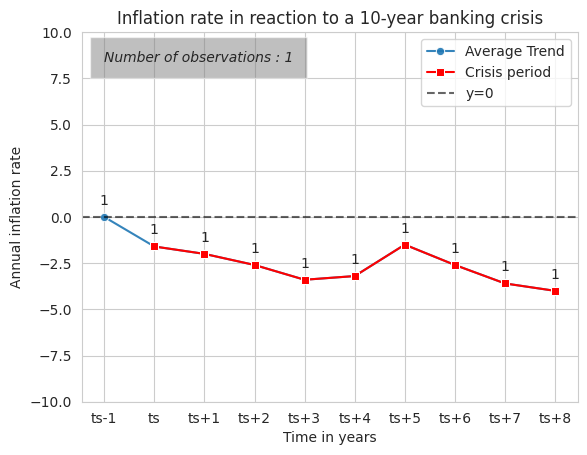

In [30]:
# Plot the average reaction of the inflation rate to banking crisis of a particular length specified in the last argument of the following function
plot_all_crisis_length(norm_inflation_series, crisis_duration_left, frequency_table_left, 'Inflation rate')

# 3. Output-gap analysis

## Dataset creation

This cell creates a dataset containing the data for the countries selected.

- The `concat_dataset` function is then called to create a dataset (`global_data_inner`) by concatenating the data from two datasets (`data` and `GDP_pc`) for the selected countries with a type of jointure `Inner` on the *Year* and *Country Code* columns. This type of jointure is used to avoid NaN values in the *output_gap* column as the `GDP_pc` does not have data as old as the `main_data` database.

- The `dummy_variable` function is applied to the `global_data_inner` dataset to add the necessary dummy variable columns to the dataset.

In [31]:
# Create a dataset with the data of the countries of the list countries_selected
global_data_inner = concat_dataset(main_data, GDP_pc, countries_selected, 'inner')

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_inner)

# Display the resulting dataset (here the first 5 rows)
global_data_inner.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,23.0,DEU,Germany,1800,0.0,NaN,0.0,0,3.1746,NaN,...,NaN,-12.3,1,0,0.0,-7.30,0,0,0,1
1,23.0,DEU,Germany,1820,0.0,NaN,0.0,0,2.8701,NaN,...,NaN,-4.2,1,0,0.0,-14.20,0,0,0,1
2,23.0,DEU,Germany,1850,0.0,NaN,0.0,0,2.7442,NaN,...,0,-2.9,1,0,0.0,14.12,0,0,0,1
3,23.0,DEU,Germany,1851,0.0,NaN,0.0,0,2.7255,NaN,...,0,26.3,1,0,1.0,5.50,0,1,0,0
4,23.0,DEU,Germany,1852,0.0,NaN,0.0,0,2.6936,NaN,...,0,17.2,1,0,0.0,2.41,0,0,0,1


We compute a list containing the duration of all the crisis events of the dataset (`crisis_duration_inner`) and a table showing the number of crisis events for each length.  

In [32]:
# Calculate the duration of crisis events
crisis_duration_inner = compute_crisis_duration(global_data_inner)

# Compute the frequency of different crisis durations and display the table
frequency_table_inner = length_frequency(crisis_duration_inner)
frequency_table_inner

,Length in years,Count
0,1,25
1,2,14
2,3,7
3,4,3
4,7,2
5,8,1
6,10,1


## Extraction of the output gap series

Now, this cell extracts the inflation series from the `global_data_inner` dataset using the `extract_output_gap_series` function from the `extraction_method_1` module and then store the result in the list `output_gap_series`.

In [33]:
from extraction_method_2 import extract_output_gap_series

output_gap_series = extract_output_gap_series(global_data_inner)

## Visualization of output gap average reaction by crisis length

This cell visualizes the average reaction of the output gap to banking crises depending on the crisis length using functions from the `visualisation` module.

The functions `plot_by_crisis_length` and `plot_all_crisis_length` from the `visualisation` module are imported. \
The two functions can be called as explained in the Inflation rate analysis part, one displaying the average reaction to a a specific duration of banking crisis, the other for every length of crisis.


Uncomment the following cell to plot the reaction for a specific length of banking crisis 📈📉.

In [34]:
# desired_length = 1 #year(s)

# # Plot the average reaction of the output gap to a banking crisis of a particular length specified in the last argument of the following function
# plot_by_crisis_length(output_gap_series, crisis_duration_inner, frequency_table_inner, 'Output gap', desired_length)

Uncomment the following cell to plot the reaction for every length of banking crisis 📈📉.

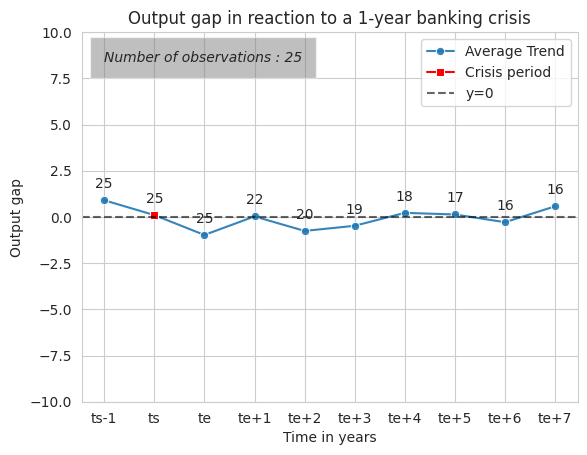

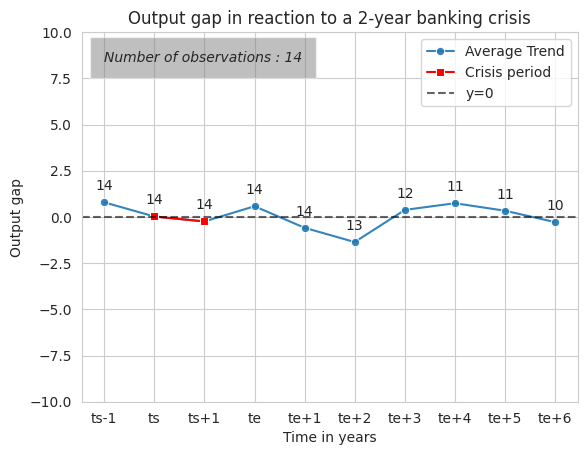

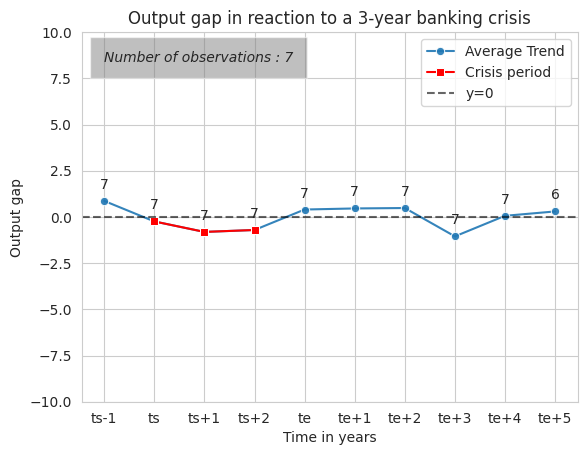

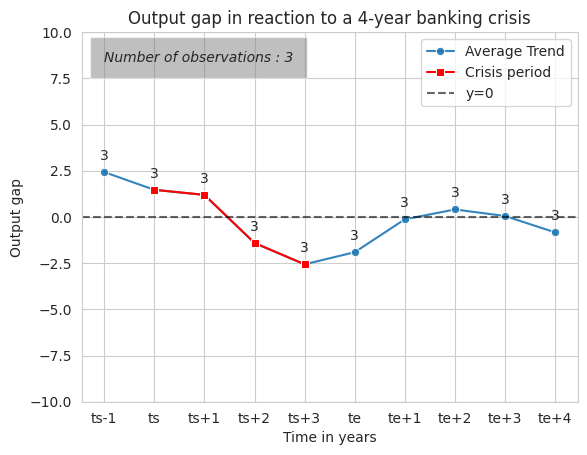

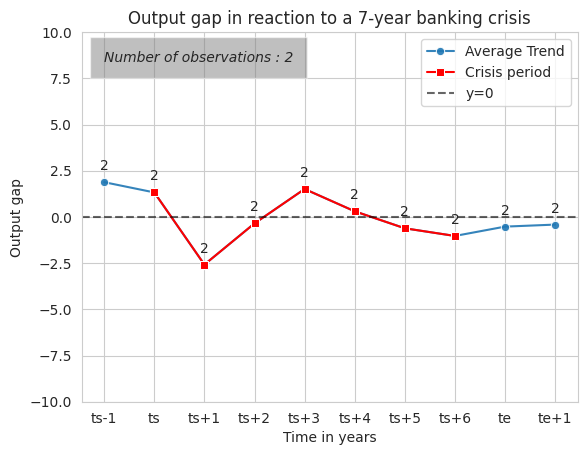

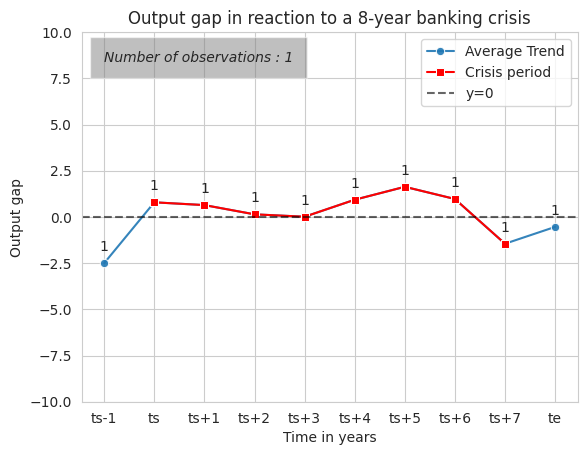

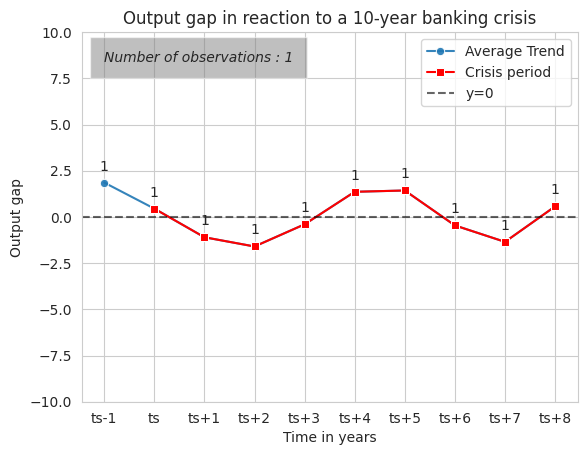

In [35]:
# Plot the average reaction of the output gap to banking crisis of all durations
plot_all_crisis_length(output_gap_series, crisis_duration_inner, frequency_table_inner, 'Output gap')

# 4. Crisis & recovery Dynamics in a multiple country database

This last part aims to study how the inflation rate & output gap variables are behaving as the banking crisis & the recovery lasts for an additional year.

We first import the functions `inflation_dynamics`, `output_gap_dynamics` and `plot_dynamics` from the `extraction_method_1` and `visualisation` modules.

In [36]:
from extraction_method_2 import inflation_dynamics
from extraction_method_2 import output_gap_dynamics
from visualisation import plot_dynamics

The `normalize_serie` function normalizes each sublist in a given list based on its first element. It takes one argument:

The `plot_dynamics` function plots the inflation rate or the output gap during banking crisis and recovery periods. It computes the average response pattern by time elapsed with the normalized inflation rate series and the output gap series. It takes three arguments:
- `crisis_series`: A list of lists representing series of a variable during banking crises.
- `recovery_series`: A list of lists representing series of a variable during recovery periods.
- `string`: A string indicating the variable being plotted (e.g., inflation rate).

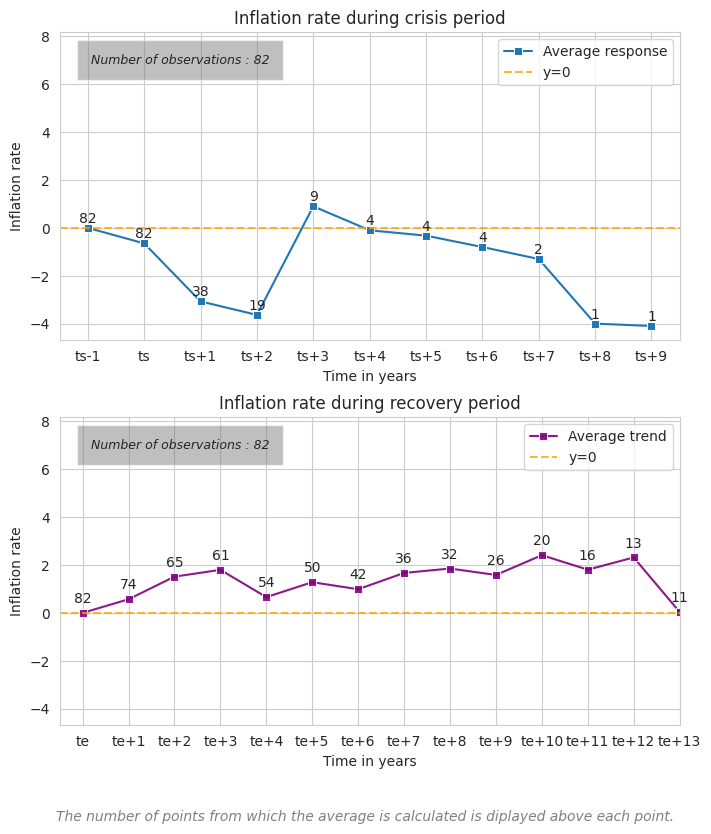

In [37]:
# Extract the inflation series only for the years marked as a banking crisis / recovery year from the global_data_left dataframe and normalize the series
inflation_crisis_series = normalize_serie(inflation_dynamics(global_data_left, during_crisis = True))
inflation_recovery_series = normalize_serie(inflation_dynamics(global_data_left, during_crisis = False))

# Compute the average evolution and plot it
plot_dynamics(inflation_crisis_series, inflation_recovery_series, 'Inflation rate')

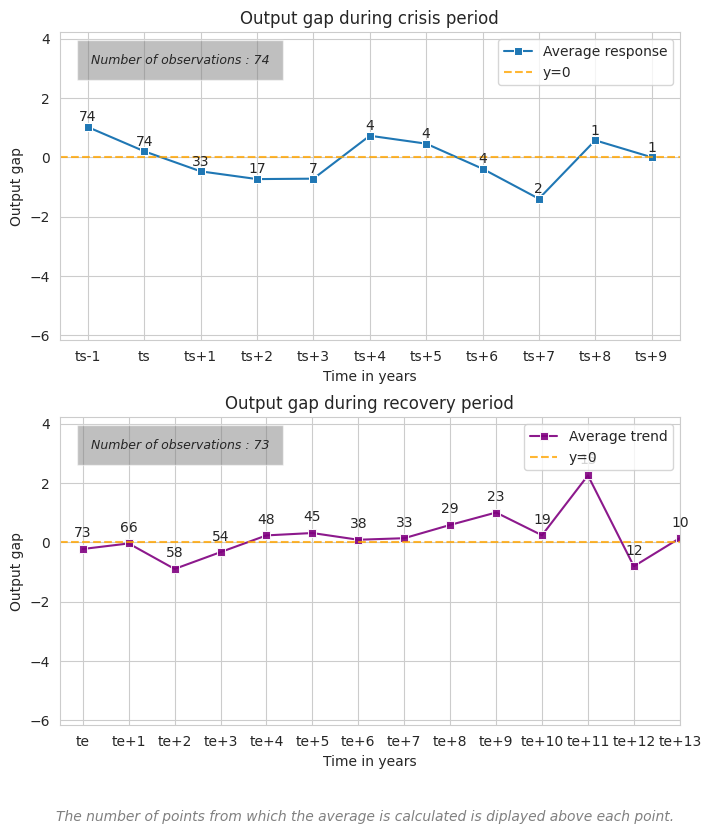

In [38]:
# Extract the inflation series only for the years marked as a banking crisis / recovery year from the global_data_left dataframe and normalize the series
output_gap_crisis_series = output_gap_dynamics(global_data_inner, during_crisis = True)
output_gap_recovery_series = output_gap_dynamics(global_data_inner, during_crisis = False)

# Compute the average evolution and plot it
plot_dynamics(output_gap_crisis_series, output_gap_recovery_series, 'Output gap')